# **Function 1: Snake Algorithm**

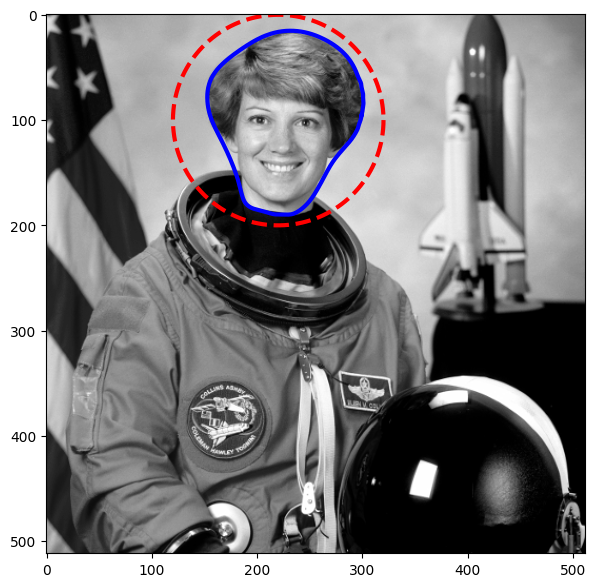

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour
import cv2 as cv2
img = data.astronaut()
img = rgb2gray(img)

s = np.linspace(0, 2*np.pi, 300)
r = 100 + 100*np.sin(s)
c = 220 + 100*np.cos(s)
init = np.array([r, c]).T

snake = active_contour(gaussian(img, 3, preserve_range=False),
                       init, alpha=0.01, beta=20, gamma=0.001)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
# ax.set_xticks([]), ax.set_yticks([])
# ax.axis([0, img.shape[1], img.shape[0], 0])

plt.show()

# **Function 2: Watershed**

link of img: https://docs.opencv.org/4.x/water_coins.jpg

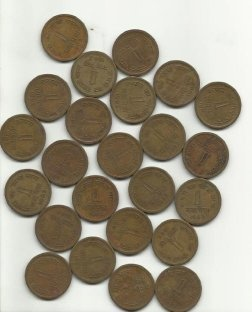

In [3]:
import cv2
import numpy as np
from IPython.display import Image, display
from matplotlib import pyplot as plt
# Plot the image
def imshow(img, ax=None):
	if ax is None:
		ret, encoded = cv2.imencode(".jpg", img)
		display(Image(encoded))
	else:
		ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
		ax.axis('off')

#Image loading
img = cv2.imread("water_coins.jpg")

#image grayscale conversion
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Show image
imshow(img)


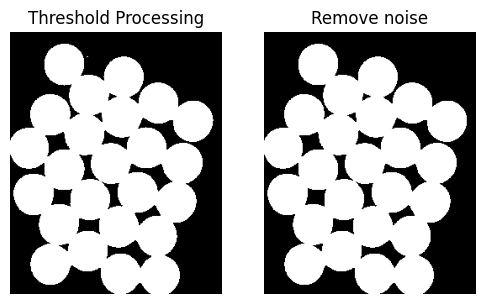

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6,6))

ret, bin_img1 = cv2.threshold(gray,
                            0, 255,
                            cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

imshow(bin_img1, axes[0])
axes[0].set_title("Threshold Processing")

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
bin_img2 = cv2.morphologyEx(bin_img1,
                            cv2.MORPH_OPEN,
                            kernel,
                            iterations=2)
imshow(bin_img2, axes[1])
axes[1].set_title("Remove noise")

plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


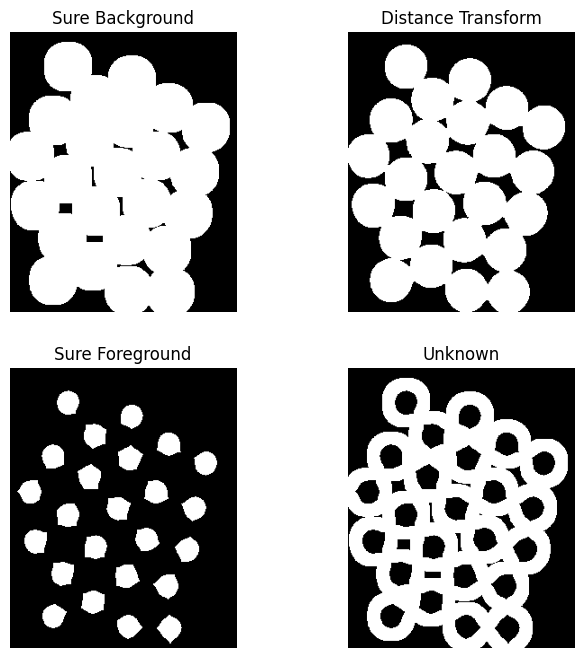

In [5]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
# sure background area
sure_bg = cv2.dilate(bin_img2, kernel, iterations=3)
imshow(sure_bg, axes[0,0])
axes[0, 0].set_title('Sure Background')

# Distance transform
dist = cv2.distanceTransform(bin_img2, cv2.DIST_L2, 5)
imshow(dist, axes[0,1])
axes[0, 1].set_title('Distance Transform')

#foreground area
ret, sure_fg = cv2.threshold(dist, 0.5 * dist.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)
imshow(sure_fg, axes[1,0])
axes[1, 0].set_title('Sure Foreground')

# unknown area
unknown = cv2.subtract(sure_bg, sure_fg)
imshow(unknown, axes[1,1])
axes[1, 1].set_title('Unknown')

plt.show()


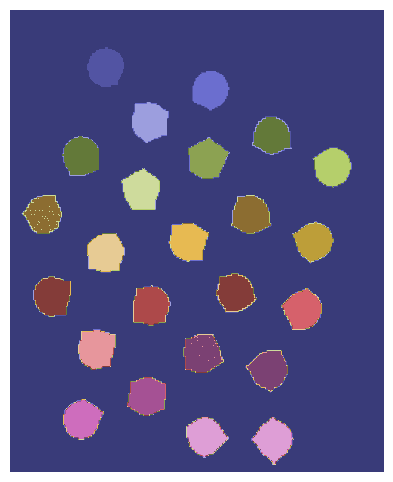

In [6]:
# Marker labelling
# sure foreground
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that background is not 0, but 1
markers += 1
# mark the region of unknown with zero
markers[unknown == 255] = 0

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()


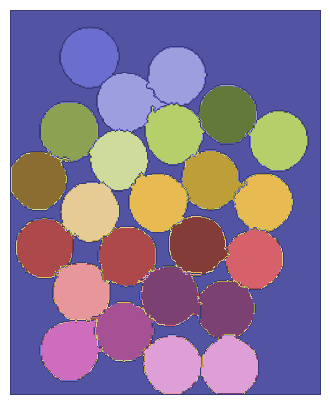

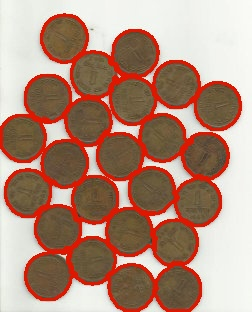

In [7]:
# watershed Algorithm
markers = cv2.watershed(img, markers)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()


labels = np.unique(markers)

coins = []
for label in labels[2:]:

# Create a binary image in which only the area of the label is in the foreground
#and the rest of the image is in the background
	target = np.where(markers == label, 255, 0).astype(np.uint8)
	
# Perform contour extraction on the created binary image
	contours, hierarchy = cv2.findContours(
		target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
	)
	coins.append(contours[0])

# Draw the outline
img = cv2.drawContours(img, coins, -1, color=(0, 23, 223), thickness=2)
imshow(img)


# **K-Means Clustering for Image Segmentation**

Link of img: https://upload.wikimedia.org/wikipedia/commons/thumb/6/62/Paracas_National_Reserve%2C_Ica%2C_Peru-3April2011.jpg/800px-Paracas_National_Reserve%2C_Ica%2C_Peru-3April2011.jpg

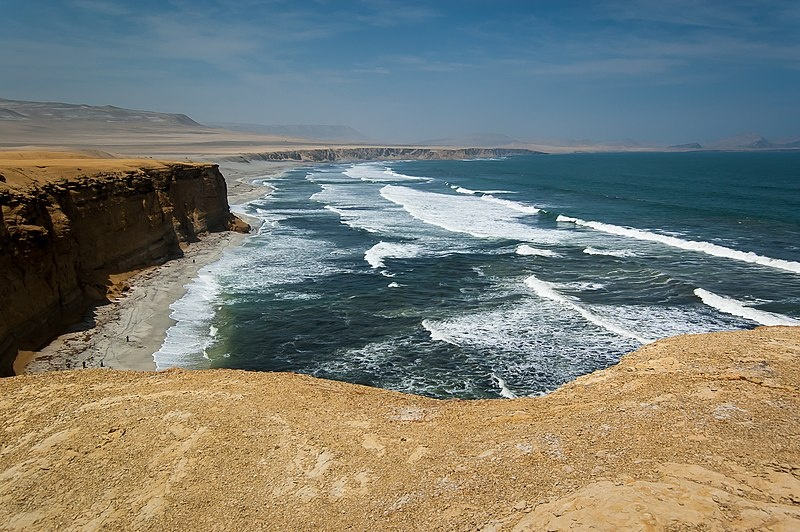

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

original_image = cv2.imread("sea.jpg")
imshow(original_image)

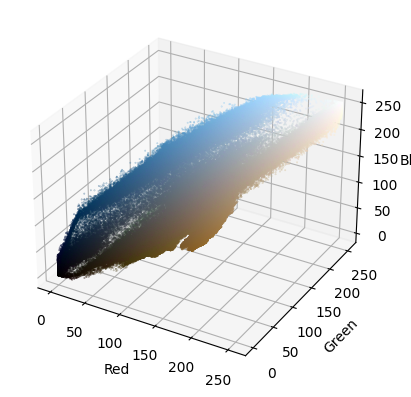

In [9]:
height, width, channels = original_image.shape
img_data = original_image.reshape(height * width, channels)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(img_data[:,0], img_data[:,1], img_data[:,2], c=img_data/255.0, s=0.1)
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')
plt.show()

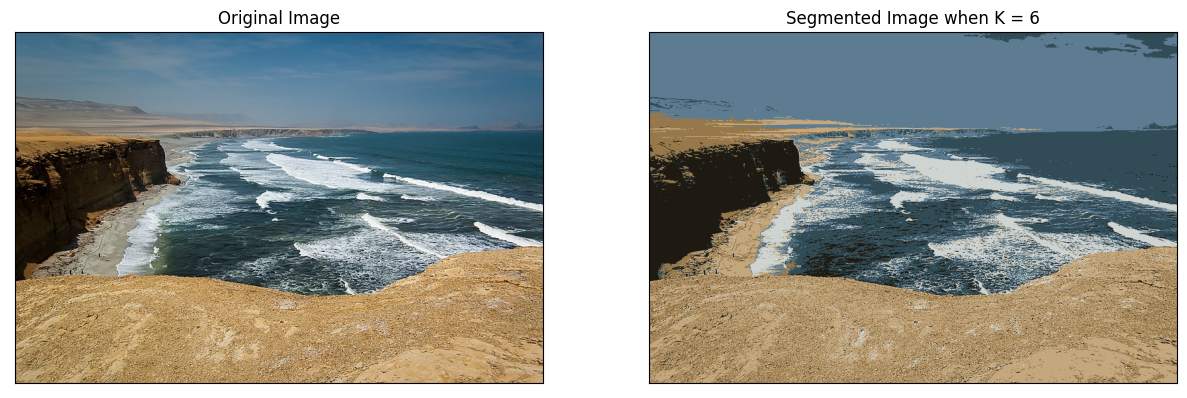

In [10]:
original_image = cv2.imread("sea.jpg")
img=cv2.cvtColor(original_image,cv2.COLOR_BGR2RGB)

# converts the MxNx3 image into a Kx3 matrix where K=MxN
vectorized = img.reshape((-1,3))

# convert the unit8 values to float as it is a requirement of the k-means method of OpenCV.
vectorized = np.float32(vectorized)

# Define criteria, number of clusters(K) and apply k-means()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 6
attempts=10
ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)

center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((img.shape))

figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(result_image)
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()



**Find optimal K by Elbow method**

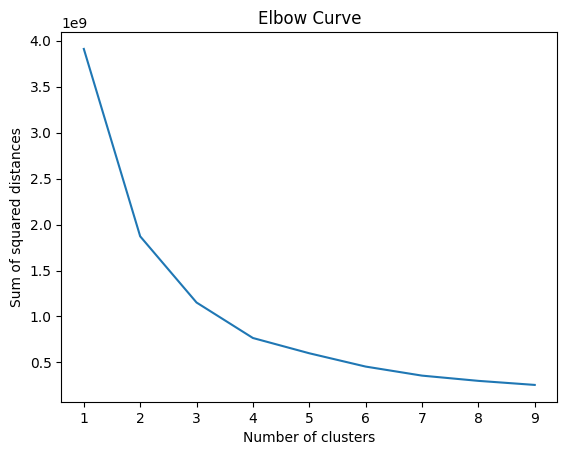

In [11]:
from sklearn.cluster import KMeans

# Sum of squared distances for each k
distortions = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, n_init=10).fit(vectorized)
    distortion = kmeans.inertia_
    distortions.append(distortion)

# Plot the elbow curve
plt.plot(range(1, 10), distortions)
plt.title('Elbow Curve')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.show()


# **Mean Shift**

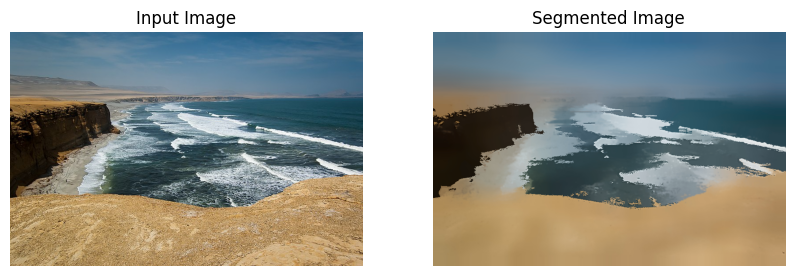

In [12]:
import cv2

img = cv2.imread('sea.jpg')

# convert image to Lab color space
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

# apply meanshift filtering
ms = cv2.pyrMeanShiftFiltering(lab, 25, 45)

# convert back to BGR color space
result = cv2.cvtColor(ms, cv2.COLOR_LAB2BGR)

# display results
fig, axs = plt.subplots(1, 2, figsize=(10, 10))

axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0].set_title('Input Image')
axs[0].axis('off')

axs[1].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
axs[1].set_title('Segmented Image')
axs[1].axis('off')

plt.show()